### Evaluate performance of saved model on test data

In [1]:
from collections import deque
from hmmlearn import hmm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
from tqdm import tqdm


from itertools import cycle
from sklearn.preprocessing import LabelBinarizer

from src.models import *
from src.dl_model_utils import Cholec80Dataset, get_transform_test
from src.eval_utils import *

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix,roc_auc_score,roc_curve,auc)

In [4]:
model_path = 'models/DeiT_ord_od_model.pth'
model = DeiT_Distilled_OD()
model.load_state_dict(torch.load(model_path))


model.eval()

dummy_input = torch.randn(1, 3, 224, 224)

In [5]:
input_names = [ "actual_input" ]
output_names = [ "output" ]

torch.onnx.export(model,
                 dummy_input,
                 "deitod.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )

c:\Users\vkula\anaconda3\lib\site-packages\torch\__init__.py:833: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message
c:\Users\vkula\anaconda3\lib\site-packages\timm\models\vision_transformer.py:68: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)


In [2]:
CLASS_LABELS = [
    "Preparation",
    "CalotTriangleDissection",
    "ClippingCutting",
    "GallbladderDissection",
    "GallbladderPackaging",
    "CleaningCoagulation",
    "GallbladderRetraction",
]
MODEL_NUM = 9

In [3]:
tool_combos = ['tool_Grasper', '', 'tool_Grasper, tool_Hook', 'tool_Hook',
       'tool_Grasper, tool_Irrigator', 'tool_Irrigator', 'tool_Bipolar',
       'tool_Grasper, tool_Bipolar', 'tool_Grasper, tool_Clipper',
       'tool_Clipper', 'tool_Grasper, tool_Scissors', 'tool_SpecimenBag',
       'tool_Grasper, tool_SpecimenBag', 'tool_Scissors',
       'tool_Grasper, tool_Bipolar, tool_Irrigator',
       'tool_Bipolar, tool_Irrigator', 'tool_Bipolar, tool_SpecimenBag',
       'tool_Grasper, tool_Bipolar, tool_SpecimenBag',
       'tool_Irrigator, tool_SpecimenBag',
       'tool_Bipolar, tool_Irrigator, tool_SpecimenBag',
       'tool_Grasper, tool_Irrigator, tool_SpecimenBag',
       'tool_Grasper, tool_Clipper, tool_Irrigator',
       'tool_Clipper, tool_Irrigator',
       'tool_Grasper, tool_Clipper, tool_SpecimenBag',
       'tool_Grasper, tool_Scissors, tool_SpecimenBag',
       'tool_Hook, tool_Irrigator',
       'tool_Grasper, tool_Hook, tool_Irrigator',
       'tool_Bipolar, tool_Scissors']


INSTRUMENT_MAP = {
    '':0,
    'tool_Grasper':1,
    'tool_Grasper, tool_Hook':2,
    'tool_Hook':3,
    'tool_Grasper, tool_Irrigator':4,
    'tool_Irrigator':5,
    'tool_Bipolar':6,
    'tool_Grasper, tool_Bipolar':7,
    'tool_Grasper, tool_Clipper':8,
    'tool_Clipper':9,
    'tool_Grasper, tool_Scissors':10,
    'tool_SpecimenBag':11,
    'tool_Grasper, tool_SpecimenBag':12,
    'tool_Scissors':13,
    'tool_Grasper, tool_Bipolar, tool_Irrigator':14,
    'tool_Bipolar, tool_Irrigator':15,
    'tool_Bipolar, tool_SpecimenBag':16,
    'tool_Grasper, tool_Bipolar, tool_SpecimenBag':17,
    'tool_Irrigator, tool_SpecimenBag':18,
    'tool_Bipolar, tool_Irrigator, tool_SpecimenBag':19,
    'tool_Grasper, tool_Irrigator, tool_SpecimenBag':20,
    'tool_Grasper, tool_Clipper, tool_Irrigator':21,
    'tool_Clipper, tool_Irrigator':22,
    'tool_Grasper, tool_Clipper, tool_SpecimenBag':23,
    'tool_Grasper, tool_Scissors, tool_SpecimenBag':24,
    'tool_Hook, tool_Irrigator':25,
    'tool_Grasper, tool_Hook, tool_Irrigator':26,
    'tool_Bipolar, tool_Scissors':27
    }

In [4]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device Type : {}".format(device))

#Select model for evaluation and import
model, hmm_emission_df = model_select(model_num=MODEL_NUM)
model.to(device)
print('Model Loaded..')

Device Type : cuda
Model Loaded..


In [5]:
#Dataframe import for hmm emission data and test data for eval
test_df = pd.read_parquet('data/ordered_test_df.parquet')
test_df = test_df[test_df['frame'] % 25 == 0].reset_index(drop=True)
test_df['tool_target'] = test_df[['tool_Grasper', 'tool_Bipolar',
        'tool_Hook', 'tool_Scissors', 'tool_Clipper', 'tool_Irrigator',
        'tool_SpecimenBag']].dot(test_df[['tool_Grasper', 'tool_Bipolar',
        'tool_Hook', 'tool_Scissors', 'tool_Clipper', 'tool_Irrigator',
        'tool_SpecimenBag']].columns + ', ').str.rstrip(', ').map(INSTRUMENT_MAP).values

hmm_train_df = pd.read_parquet('data/ordered_train_df.parquet')

hmm_emission_df['target'] = hmm_train_df[hmm_train_df['frame'] % 25 == 0].phase.values

In [7]:
from sklearn.ensemble import RandomForestClassifier


In [8]:
X_train = hmm_emission_df.cnn_output.to_numpy()
y_train = hmm_emission_df.target.to_numpy()

In [10]:
# instantiate the classifier 
random_forest = RandomForestClassifier(n_estimators=200,criterion='entropy',class_weight='balanced',random_state=42,verbose=2)

# fit
random_forest.fit(np.vstack(np.ravel(X_train)), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.3min finished


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=200, random_state=42, verbose=2)

In [11]:
#Create test loader
testset = Cholec80Dataset(test_df,  get_transform_test())
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False
)

# Get network prediction accuracy on the test images
grouth_truth_classes = []
predicted_classes = []
total = 0
correct = 0

#Outputs for HMM
img_path_test_list = []
soft_max_out_test = []

for data in tqdm(testloader):
    inputs, img_id, labels, tools  = data

    inputs = inputs.to(device)
    tools = tools.to(device)

    test_outputs_tool, sigmoid_outputs  = model.forward(inputs)
    test_preds = (sigmoid_outputs > 0.5).float()

    img_path_test_list = img_path_test_list + (list(img_id))
    grouth_truth_classes = grouth_truth_classes + labels.tolist()
    soft_max_out_test = soft_max_out_test + test_outputs_tool.tolist()
    predicted_classes = predicted_classes + test_preds.tolist()

results_df = pd.DataFrame(
    {'img_path': img_path_test_list,
        'true_labels': grouth_truth_classes,
        'cnn_output': soft_max_out_test,
        'predicted_labels': predicted_classes
    })
results_df['video_num'] = test_df['video_num']

#Save model inference
results_df.to_parquet(f'results/model_{MODEL_NUM}_od_results_df.parquet')
    

100%|██████████| 600/600 [15:48<00:00,  1.58s/it]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.1s finished


In [19]:
vid_name = results_df['video_num'].iloc[0]
print(f"Start decoding vid {vid_name}:  ...")
ground_truth = results_df['true_labels'].to_numpy()
vision_prediction = results_df['predicted_labels'].to_numpy()
ma_probs = np.array([np.array(xi) for xi in results_df['cnn_output'].to_numpy()])
vision_probs = np.array([np.array(xi) for xi in results_df['cnn_output'].to_numpy()])

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

In [20]:
accuracy_score(results_df.true_labels.values, y_pred)

0.38774207832462915

In [24]:
# for video in results_df['video_num'].unique():
#     vid_results_df = results_df[results_df['video_num'] == video]
#     y_gt = vid_results_df['true_labels']
#     y_pred = random_forest.predict(np.vstack(np.ravel(vid_results_df.cnn_output.to_numpy())))
    
#     print(classification_report(y_gt, y_pred))
#     show_ribbon_plot(y_gt,'Ground Truth')

#     show_ribbon_plot(y_pred,'Prediction')




In [ ]:
#Create test loader
testset = Cholec80Dataset(test_df,  get_transform_test())
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False
)

# Get network prediction accuracy on the test images
grouth_truth_classes = []
predicted_classes = []
total = 0
correct = 0

#Outputs for HMM
img_path_test_list = []
soft_max_out_test = []

for data in tqdm(testloader):
    inputs, img_id, labels, tools  = data



    inputs = inputs.to(device)
    tools = tools.to(device)

    test_outputs_phase = model(inputs)
    _, test_preds_phase = torch.max(test_outputs_phase.data.cpu(), 1)


    img_path_test_list = img_path_test_list + (list(img_id))
    grouth_truth_classes = grouth_truth_classes + labels.tolist()
    soft_max_out_test = soft_max_out_test + test_outputs_phase.tolist()
    predicted_classes = predicted_classes + test_preds_phase.tolist()


    total += labels.size(0)
    correct += (test_preds_phase == labels).sum().item()
        

results_df = pd.DataFrame(
    {'img_path': img_path_test_list,
        'true_labels': grouth_truth_classes,
        'cnn_output': soft_max_out_test,
        'predicted_labels': predicted_classes
    })
results_df['video_num'] = test_df['video_num']

#Save model inference
results_df.to_parquet(f'results/model_{MODEL_NUM}_results_df.parquet')

### Initialize HMM 

In [6]:
def get_initial_prob(df):
    initial_prob_list_phase = []
    initial_prob_list_tool = []

    initial_df = df.groupby('video_num').nth(1)
    tool_presence_values = initial_df[['tool_Grasper', 'tool_Bipolar',
        'tool_Hook', 'tool_Scissors', 'tool_Clipper', 'tool_Irrigator',
        'tool_SpecimenBag']].dot(initial_df[['tool_Grasper', 'tool_Bipolar',
        'tool_Hook', 'tool_Scissors', 'tool_Clipper', 'tool_Irrigator',
        'tool_SpecimenBag']].columns + ', ').str.rstrip(', ').map(INSTRUMENT_MAP).values
    initial_df['instr_target'] = tool_presence_values

    initial_phase_df = initial_df.groupby('phase').count()
    initial_tool_df = initial_df.groupby('instr_target').count()

    for phase in df['phase'].unique():
        if phase in initial_phase_df.index:
            single_phase_prob = initial_phase_df[initial_phase_df.index == phase].iloc[:,0].values[0] / df['video_num'].unique().shape[0]
        else:
            single_phase_prob = 0
        initial_prob_list_phase.append(single_phase_prob)

    for instrument_combo in INSTRUMENT_MAP.values():
        if instrument_combo in  initial_tool_df.index:
            single_tool_prob = initial_tool_df[initial_tool_df.index == instrument_combo].iloc[:,0].values[0] / df['video_num'].unique().shape[0]
        else:
            single_tool_prob = 0
        initial_prob_list_tool.append(single_tool_prob)

    return initial_prob_list_phase,initial_prob_list_tool

In [7]:
pi_phase,pi_tool = get_initial_prob(hmm_train_df)

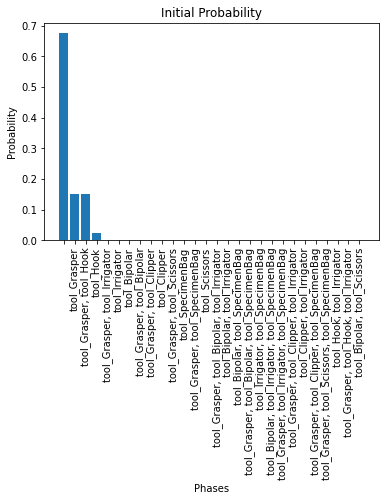

In [8]:
#Return initial hmm probabilities 
# pi = get_initial_prob(hmm_train_df)

# Visualise initial probabilities
plt.bar(x= INSTRUMENT_MAP.keys(), height=pi_tool)
plt.xticks(range(len(INSTRUMENT_MAP.keys())), INSTRUMENT_MAP.keys(), rotation=90)
plt.ylabel("Probability")
plt.xlabel("Phases")
plt.title("Initial Probability")
plt.show()

In [9]:
hmm_train_df['instr_cat'] = hmm_train_df[['tool_Grasper', 'tool_Bipolar',
        'tool_Hook', 'tool_Scissors', 'tool_Clipper', 'tool_Irrigator',
        'tool_SpecimenBag']].dot(hmm_train_df[['tool_Grasper', 'tool_Bipolar',
        'tool_Hook', 'tool_Scissors', 'tool_Clipper', 'tool_Irrigator',
        'tool_SpecimenBag']].columns + ', ').str.rstrip(', ').map(INSTRUMENT_MAP).values

<ipython-input-10-4e92fb29a5ba>:9: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(transmtrx_final), interpolation='nearest')


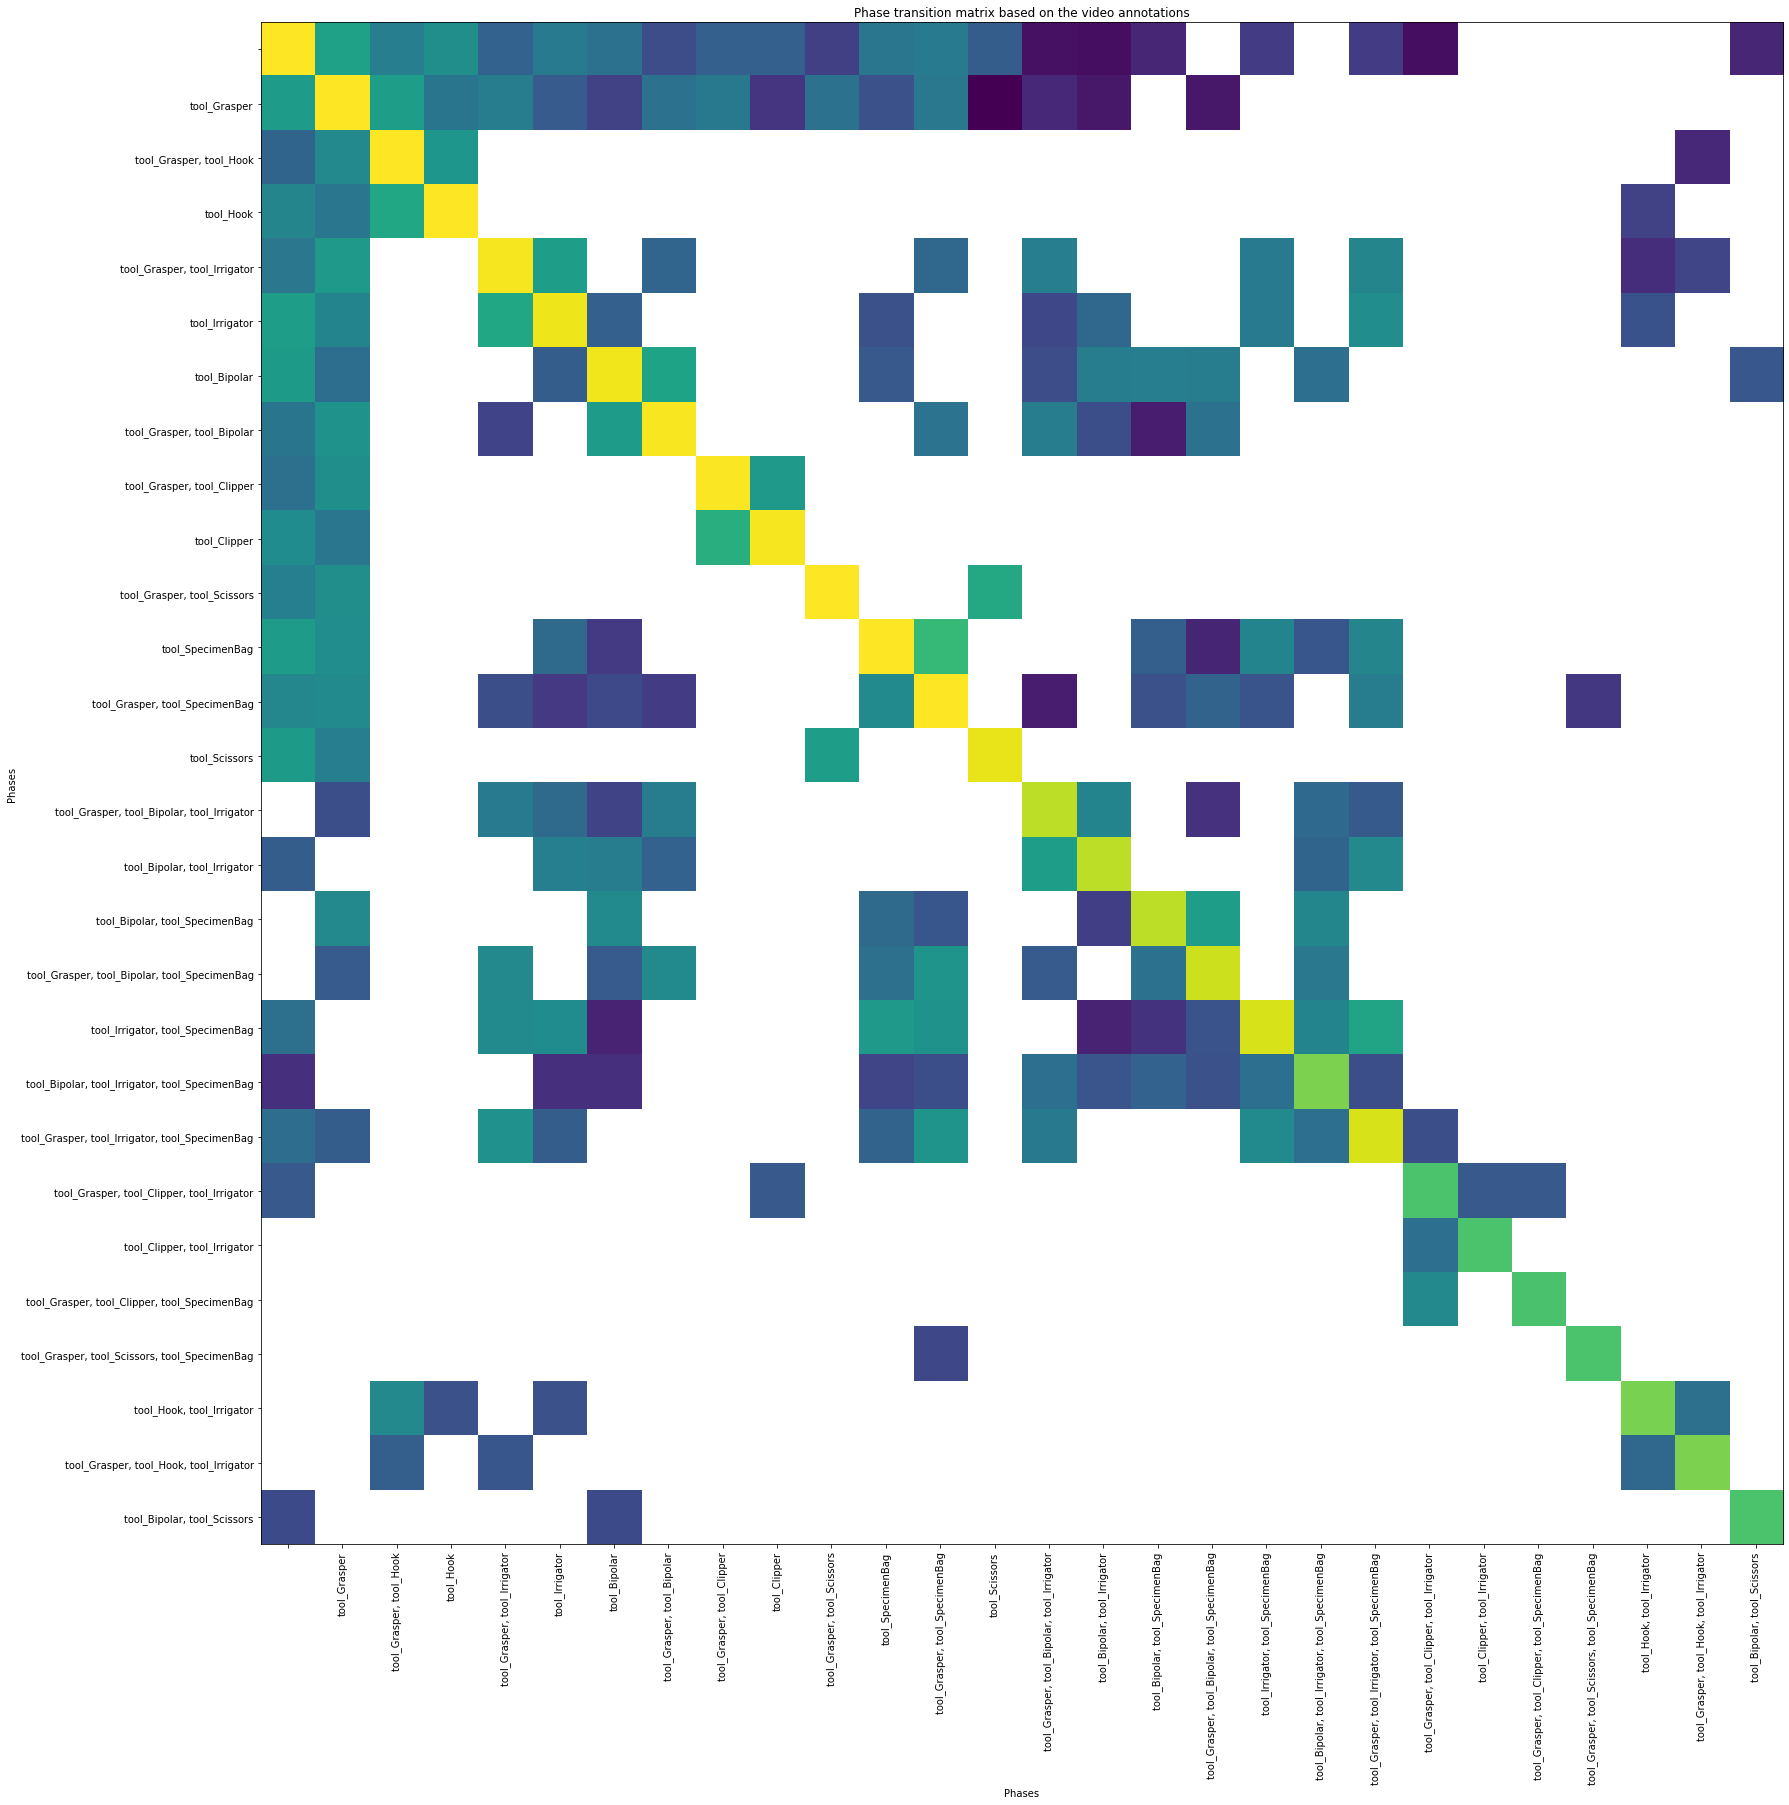

In [10]:
transmtrx_list = []
for video in hmm_train_df['video_num'].unique():
    transmtrx = get_transition_matrix(hmm_train_df[hmm_train_df['video_num'] == video]['instr_cat'].values,28)
    transmtrx_list.append(transmtrx)

transmtrx_final = np.divide(np.sum(transmtrx_list, axis=0), hmm_train_df['video_num'].unique().shape[0])

plt.figure(figsize=(28, 28))
plt.imshow(np.log(transmtrx_final), interpolation='nearest')
plt.xticks(range(len(INSTRUMENT_MAP.keys())), INSTRUMENT_MAP.keys(), rotation=90)
plt.yticks(range(len(INSTRUMENT_MAP.keys())), INSTRUMENT_MAP.keys())
plt.xlabel("Phases")
plt.ylabel("Phases")
plt.title("Phase transition matrix based on the video annotations")
plt.show()   

In [11]:
# Create dataFrame for emission probabilities
train_pred_seq_df = hmm_emission_df[["img_path", "true_labels", "cnn_output"]]

In [12]:
probas_by_phases = [[] for _ in range(len(INSTRUMENT_MAP.keys()))]
for vidId, group in train_pred_seq_df.groupby("img_path"):
    probas = np.array(group["cnn_output"].tolist())
    classes = group["true_labels"].tolist()
    for i in range(len(probas)):
        probas_by_phases[classes[i]].append(probas[i])


In [13]:
# Compute sigmas & mus for 7 phases
mus = np.zeros((28,28))
sigmas = np.zeros((28,28,28))

for i in range(28):
    X = np.array(probas_by_phases[i])
    mus[i, :] = np.mean(X, axis=0)
    sigmas[i, :, :] = np.cov(X, rowvar=False)

In [14]:
# Initialise HMM
hmm_model = hmm.GaussianHMM(n_components=28, covariance_type="diag", tol=15, verbose=True)
hmm_model.startprob_ = pi_tool
hmm_model.transmat_ = transmtrx_final
hmm_model.means_ = mus
hmm_model.covars_ = np.array([np.diag(i) for i in sigmas])

### Vision Inference

In [23]:
#Create test loader
testset = Cholec80Dataset(test_df,  get_transform_test())
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False
)

# Get network prediction accuracy on the test images
grouth_truth_classes = []
predicted_classes = []
total = 0
correct = 0

#Outputs for HMM
img_path_test_list = []
soft_max_out_test = []

for data in tqdm(testloader):
    inputs, img_id, labels, tools, tool_targets  = data

    inputs = inputs.to(device)
    # tool_targets = tool_targets.to(device)

    test_outputs_tool, sigmoid_outputs  = model.forward(inputs)
    _, test_preds_phase = torch.max(test_outputs_tool.data.cpu(), 1)


    img_path_test_list = img_path_test_list + (list(img_id))
    grouth_truth_classes = grouth_truth_classes + tool_targets.tolist()
    soft_max_out_test = soft_max_out_test + test_outputs_tool.tolist()
    predicted_classes = predicted_classes + test_preds_phase.tolist()


    total += tool_targets.size(0)
    correct += (test_preds_phase == tool_targets).sum().item()
        

results_df = pd.DataFrame(
    {'img_path': img_path_test_list,
        'true_labels': grouth_truth_classes,
        'cnn_output': soft_max_out_test,
        'predicted_labels': predicted_classes
    })
results_df['video_num'] = test_df['video_num']

#Save model inference
results_df.to_parquet(f'results/model_{MODEL_NUM}_od_28target_results_df.parquet')

100%|██████████| 600/600 [15:50<00:00,  1.58s/it]


In [11]:
#Create test loader
testset = Cholec80Dataset(test_df,  get_transform_test())
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False
)

# Get network prediction accuracy on the test images
grouth_truth_classes = []
predicted_classes = []
total = 0
correct = 0

#Outputs for HMM
img_path_test_list = []
soft_max_out_test = []

for data in tqdm(testloader):
    inputs, img_id, labels, tools  = data



    inputs = inputs.to(device)
    tools = tools.to(device)


    test_outputs_phase = model(inputs)
    _, test_preds_phase = torch.max(test_outputs_phase.data.cpu(), 1)


    img_path_test_list = img_path_test_list + (list(img_id))
    grouth_truth_classes = grouth_truth_classes + labels.tolist()
    soft_max_out_test = soft_max_out_test + test_outputs_phase.tolist()
    predicted_classes = predicted_classes + test_preds_phase.tolist()


    total += labels.size(0)
    correct += (test_preds_phase == labels).sum().item()
        

results_df = pd.DataFrame(
    {'img_path': img_path_test_list,
        'true_labels': grouth_truth_classes,
        'cnn_output': soft_max_out_test,
        'predicted_labels': predicted_classes
    })
results_df['video_num'] = test_df['video_num']

#Save model inference
results_df.to_parquet(f'results/model_{MODEL_NUM}_results_df.parquet')

100%|██████████| 600/600 [12:42<00:00,  1.27s/it]


In [12]:
try: results_df
except : results_df = pd.read_parquet(f'results/model_{MODEL_NUM}_results_df.parquet')

In [16]:
results_df= pd.read_parquet(f'results/model_{MODEL_NUM}_od_28target_results_df.parquet')

In [17]:
all_vid_prec = []
all_vid_rec = []
all_vid_f1 = []
all_vid_acc = []
all_vid_class_rep = []
all_ground_truth = []
all_pred = []

for video in results_df['video_num'].unique():
    vid_results_df = results_df[results_df['video_num'] == video]
    hmm_prec, hmm_rec,hmm_f1,accuracy, class_rep,gt,pred = single_vid_eval(vid_results_df,hmm_model=hmm_model,classes=INSTRUMENT_MAP.keys())

    all_vid_prec.append(hmm_prec)
    all_vid_rec.append(hmm_rec)
    all_vid_f1.append(hmm_f1)
    all_vid_acc.append(accuracy)
    all_vid_class_rep.append(class_rep)
    all_ground_truth.append(gt)
    all_pred.append(pred)
    

Start decoding vid video49:  ...


ValueError: transmat_ rows must sum to 1 (got [1.    1.    1.    1.    0.825 0.725 0.775 0.875 0.95  0.825 1.    0.975
 1.    0.65  0.275 0.275 0.275 0.375 0.475 0.075 0.45  0.025 0.025 0.025
 0.025 0.075 0.075 0.025])

In [14]:
print(f'Precision mean for all vids is: {np.mean(all_vid_prec)} +- {1.96 * np.std(all_vid_prec) / np.sqrt(len(all_vid_prec))}')
print(f'Recall mean for all vids is: {np.mean(all_vid_rec)} +- {1.96 * np.std(all_vid_rec) / np.sqrt(len(all_vid_rec))}')
print(f'F1 Score mean for all vids is: {np.mean(all_vid_f1)} +- {1.96 * np.std(all_vid_f1) / np.sqrt(len(all_vid_f1))}')
print(f'Accuracy mean for all vids is: {np.mean(all_vid_acc)} +- {1.96 * np.std(all_vid_acc) / np.sqrt(len(all_vid_acc))}')

Precision mean for all vids is: 0.9031409219303623 +- 0.027732913350205095
Recall mean for all vids is: 0.8205360243500657 +- 0.06101899114379726
F1 Score mean for all vids is: 0.819975761890904 +- 0.06913198071065338
Accuracy mean for all vids is: 0.8205360243500657 +- 0.06101899114379726


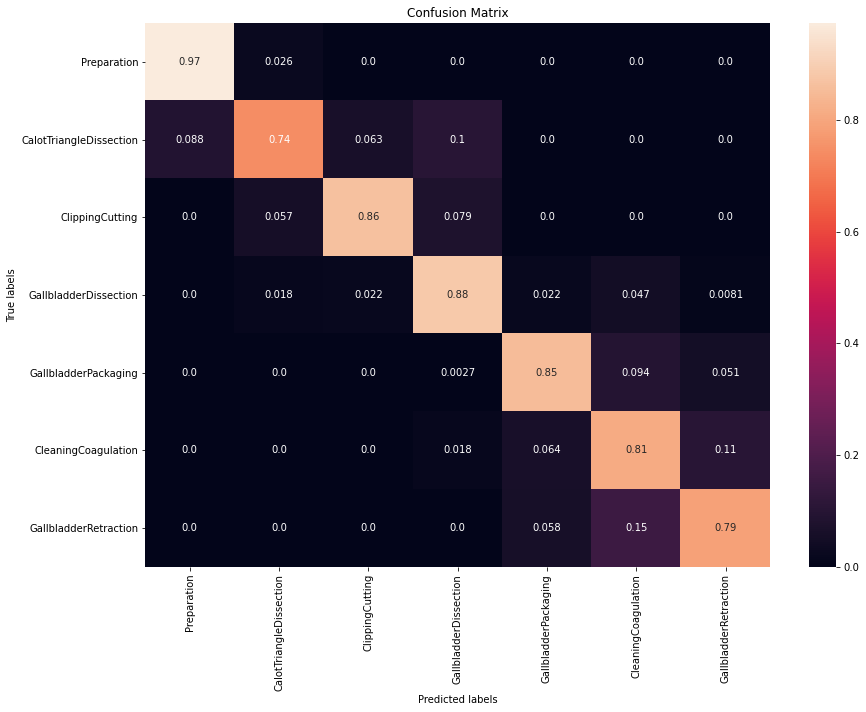

In [15]:
# get a confusion matrix
cm = confusion_matrix(np.concatenate(all_ground_truth), np.concatenate(all_pred))

# Plot the confusion matrix
fig = plt.figure(figsize=(14, 10))
ax= plt.subplot()
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2', ax=ax) 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(CLASS_LABELS, rotation=90)
ax.yaxis.set_ticklabels(CLASS_LABELS, rotation=0)
plt.show()

In [16]:
all_vid_preds = np.concatenate(all_pred)
all_vid_gt = np.concatenate(all_ground_truth)

In [17]:
print(classification_report(all_vid_gt,all_vid_preds,digits=4,labels=np.unique(all_vid_gt),target_names =CLASS_LABELS))

                         precision    recall  f1-score   support

            Preparation     0.5663    0.9737    0.7161      3568
CalotTriangleDissection     0.9624    0.7447    0.8397     30242
        ClippingCutting     0.6523    0.8640    0.7434      5450
  GallbladderDissection     0.8652    0.8827    0.8739     26789
   GallbladderPackaging     0.7060    0.8528    0.7725      3016
    CleaningCoagulation     0.6885    0.8135    0.7458      5223
  GallbladderRetraction     0.6818    0.7884    0.7312      2495

               accuracy                         0.8223     76783
              macro avg     0.7318    0.8457    0.7746     76783
           weighted avg     0.8503    0.8223    0.8265     76783



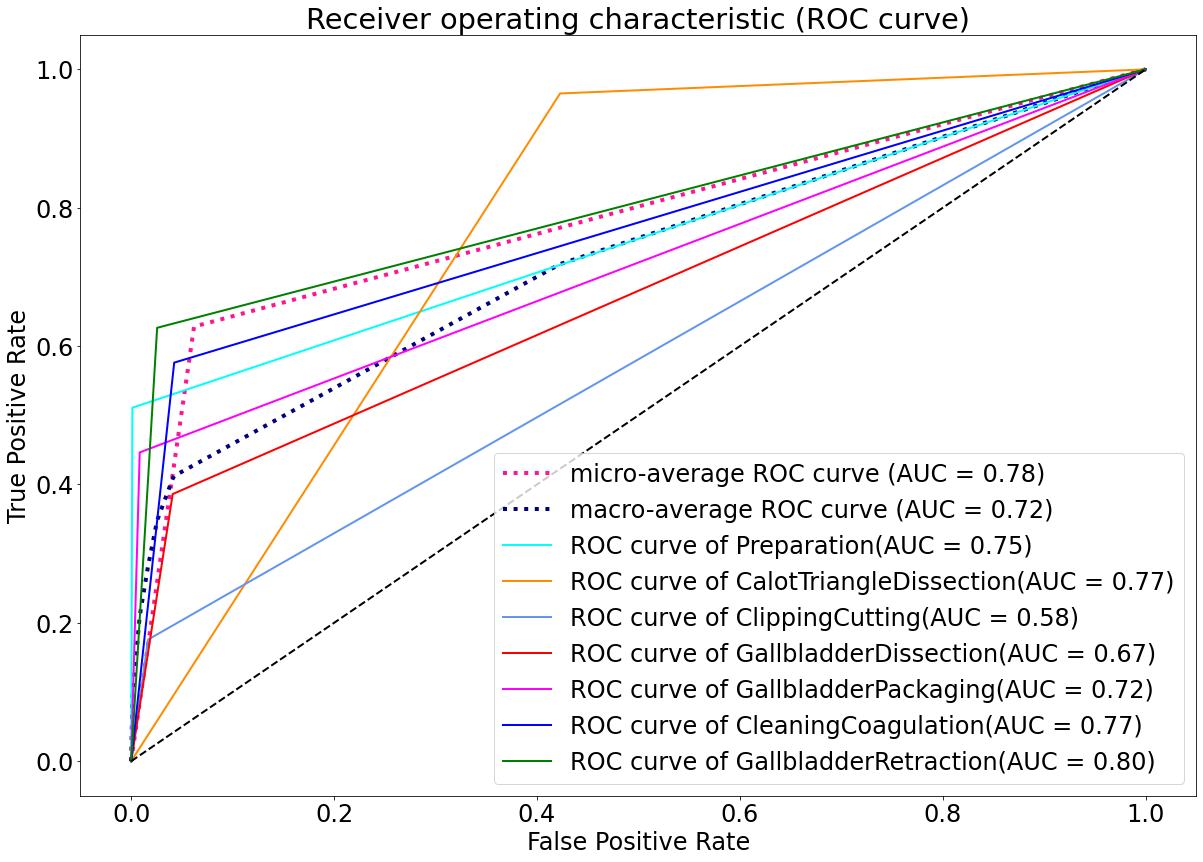

In [18]:
# plot the ROC curve
n_classes = 7
lw = 2

lb = LabelBinarizer()
lb.fit(all_vid_gt)

y_actual = lb.transform(all_vid_gt)
y_pred = lb.transform(all_vid_preds)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(
        y_actual[:, i], y_pred[:, i], drop_intermediate=True)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

font = {"family": "DejaVu Sans", "size": 24}
plt.rc("font", **font)
# Plot all ROC curves
plt.figure(figsize=(20, 14))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (AUC = {0:0.2f})" "".format(
        roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (AUC = {0:0.2f})" "".format(
        roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(
    ["aqua", "darkorange", "cornflowerblue", "red", "magenta", "blue", "green"]
)


for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of " + str(CLASS_LABELS[i]) + "(AUC = {1:0.2f})"
        "".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
# plt.xlim([0.0, 1.00])
# plt.ylim([0.0, 1.00])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC curve)")
plt.legend(loc="lower right")
plt.show()